# Lab 3
##### CS 3450 - Deep Learning
#### Mitchell Johnstone

## Introduction
This lab works with a simple dataset in order to demonstrate the functionality of a simple network. The network is defined for us, with one hidden layer, usually with around 3 hidden nodes. We had to compute the network values by hand and then compute the network values in pytorch to verify our work. Then, since this lab is focussing only on the forward pass component, we compute the forward pass as we found in our defined equations and then use Pytorch's parameter gradients to process the backwards propagation.

## Setup

In [1]:
import os
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# For simple regression problem
TRAINING_POINTS = 1000

## Data Set

In [3]:
def create_linear_training_data():
    """
    This method simply rotates points in a 2D space.
    Be sure to use MSE in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    y = torch.cat((-x2, x1), axis=0)
    return x, y

## Checking the Network

First, we'll need to define our network structure. We've already got a basis from the lab document, so we'll use those names.

We need to do some some simple testing to ensure our network structure is as we expect.

In [4]:
x = torch.tensor([[0.1, 0.9]])
x

tensor([[0.1000, 0.9000]])

In [5]:
W = torch.tensor([[1.0, 2, 3], [9, 8, 7]])
W

tensor([[1., 2., 3.],
        [9., 8., 7.]])

In [6]:
b = torch.tensor([[0.8, 0.6, 0.4]])
b

tensor([[0.8000, 0.6000, 0.4000]])

In [7]:
u = x@W + b
u

tensor([[9.0000, 8.0000, 7.0000]])

In [8]:
h = u * (u>0)
h

tensor([[9.0000, 8.0000, 7.0000]])

In [9]:
M = torch.tensor([[0.1, 0.7], [0.1, 0.3], [0.2, 0.8]])
M

tensor([[0.1000, 0.7000],
        [0.1000, 0.3000],
        [0.2000, 0.8000]])

In [10]:
c = torch.tensor([-7, -7])
c

tensor([-7, -7])

In [11]:
v = h@M + c
v

tensor([[-3.9000,  7.3000]])

In [12]:
y = torch.tensor([[-4, 8]])
y

tensor([[-4,  8]])

In [13]:
L = (y-v)@(y-v).T
L = torch.norm(y-v)**2
L

tensor(0.5000)

In [14]:
s1 = torch.norm(W)**2
s1

tensor(208.)

In [15]:
s2 = torch.norm(M)**2
s2

tensor(1.2800)

In [16]:
s = s1 + s2
J = L + s
J

tensor(209.7800)

These match the predictions and calculations I had, so I'd expect this to be true.

## Final Network

#### Meta Parameters

In [17]:
lr = 1e-3
reg = 0

#### Network Structure

In [18]:
# TODO: Build your network.
W = torch.rand((2,3), requires_grad=True)
b = torch.zeros((1,3), requires_grad=True)
M = torch.rand((3,2), requires_grad=True)
c = torch.zeros((1,2), requires_grad=True)

In [19]:
# TODO: Select your datasource.
x_train, y_train = create_linear_training_data()
x_train, y_train = x_train.T, y_train.T

In [20]:
# TODO: Train your network.
epochs = 100
batch_size = 25
assert x_train.shape[0] % batch_size == 0

losses = []

# Batching inspired by https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
for epoch in range(epochs):
    # Permute the data
    permutation = torch.randperm(x_train.shape[0])
    
    # Run through batches
    for i in range(0,x_train.shape[0], batch_size):
        
        # Get batch
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices,:], y_train[indices,:]
        
        # forward pass
        ## First Layer
        u = batch_x@W + b
        h = u*(u>0)
        ## Second Layer
        v = h@M+c
        ## loss
        L = torch.norm(v-batch_y)**2
        # Record loss
        losses.append(L.item())
        # Objective Function
        s1 = reg*torch.norm(W)**2
        s2 = reg*torch.norm(M)**2
        s = s1+s2
        J = L+s
        
        # backward pass
        J.backward()
        
        # Update learning parameters
        W.data -= lr * W.grad
        b.data -= lr * b.grad
        M.data -= lr * M.grad
        c.data -= lr * c.grad
        
        # zero the gradients
        W.grad.zero_()
        b.grad.zero_()
        M.grad.zero_()
        c.grad.zero_()

Text(0, 0.5, 'Loss')

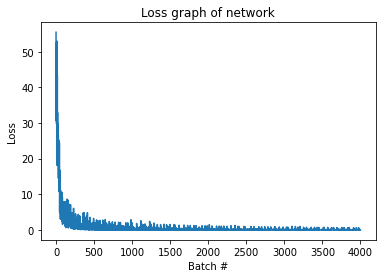

In [21]:
plt.plot(losses)
plt.title("Loss graph of network")
plt.xlabel("Batch #")
plt.ylabel("Loss")

##### Check the network weights for a linear operation.

In [22]:
# But you must computed W*M as discussed in the lab assignment.
W@M

tensor([[-0.1664,  1.0332],
        [-1.9671,  0.1905]], grad_fn=<MmBackward>)

#### Train until it's super close!

In [23]:
# TODO: Build your network.
W = torch.rand((2,3), requires_grad=True)
b = torch.zeros((1,3), requires_grad=True)
M = torch.rand((3,2), requires_grad=True)
c = torch.zeros((1,2), requires_grad=True)

In [24]:
# TODO: Select your datasource.
x_train, y_train = create_linear_training_data()
x_train, y_train = x_train.T, y_train.T

In [25]:
# TODO: Train your network.
threshhold = 1e-8
target = torch.tensor([[0, 1], [-1, 0]])
batch_size = 25
assert x_train.shape[0] % batch_size == 0

losses = []
num_epochs = 0

close = False
# Batching inspired by https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
while not close:
    # Permute the data
    permutation = torch.randperm(x_train.shape[0])
    num_epochs += 1
    
    # Run through batches
    for i in range(0,x_train.shape[0], batch_size):
        # Get batch
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices,:], y_train[indices,:]
        
        # forward pass
        ## First Layer
        u = batch_x@W + b
        h = u*(u>0)
        ## Second Layer
        v = h@M+c
        ## loss
        L = torch.norm(v-batch_y)**2
        # Record loss
        losses.append(L.item())
        # Objective Function
        s1 = reg*torch.norm(W)**2
        s2 = reg*torch.norm(M)**2
        s = s1+s2
        J = L+s
        
        # backward pass
        J.backward()
        
        # Update learning parameters
        W.data -= lr * W.grad
        b.data -= lr * b.grad
        M.data -= lr * M.grad
        c.data -= lr * c.grad
        
        # zero the gradients
        W.grad.zero_()
        b.grad.zero_()
        M.grad.zero_()
        c.grad.zero_()
        
        close = close or (threshhold >= (torch.norm(W@M - target)**2).item())

Converged in 99  epochs.


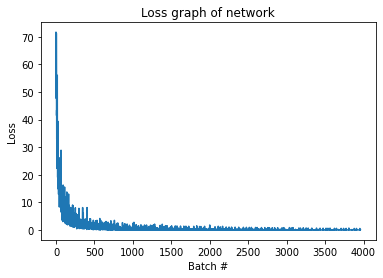

In [26]:
plt.plot(losses)
plt.title("Loss graph of network")
plt.xlabel("Batch #")
plt.ylabel("Loss")
print("Converged in", num_epochs," epochs.")

##### Check the network weights for a linear operation.

In [27]:
# But you must computed W*M as discussed in the lab assignment.
W@M

tensor([[ 0.0024,  1.0011],
        [-1.0032, -0.0014]], grad_fn=<MmBackward>)

## Conclusion
I thought this lab was really cool! The linear algebra was fairly straight forward and I enjoyed working it out by hand before confirming it in the network in the notebook. 

I'll be interested to see how the gradients are calculated. I feel like I can kind of see it already in my head, but I want to do it first. Anyways, it was cool to see. And then I loved being able to visualize the loss and compute everything myself so I felt like I had good control over the network.

It took a bit to find the right learning parameter to use, but I think that for this dataset the 1e-3 learning rate was good enough to have convergence. Too far deviating caused issues with fluctuation and slow convergence.